In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('gold_monthly_csv.csv')

In [3]:
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [4]:
df.shape

(847, 2)

# EDA

In [5]:
print(f"Data range of gold available from {df.loc[:, 'Date'][0]} to {df.loc[:, 'Date'][len(df)-1]}")

Data range of gold available from 1950-01 to 2020-07


In [6]:
date = pd.date_range(start='1/1/1950', end='8/1/2020', freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='ME')

In [7]:
df['month'] = date 
df.drop('Date', axis=1, inplace=True)
df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


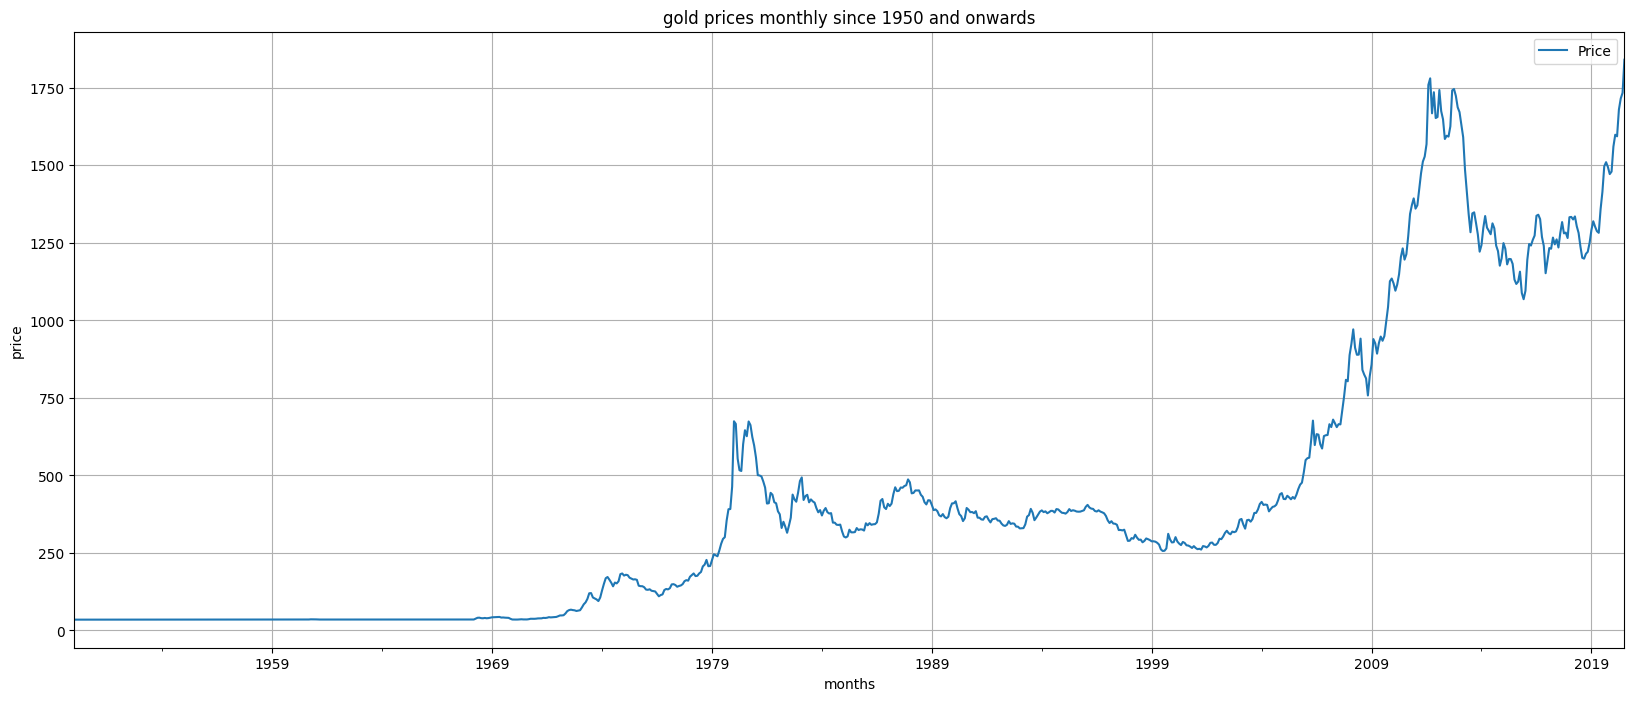

In [8]:
df.plot(figsize=(20,8))
plt.title('gold prices monthly since 1950 and onwards')
plt.xlabel('months')
plt.ylabel('price')
plt.grid()

In [9]:
round(df.describe(), 3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


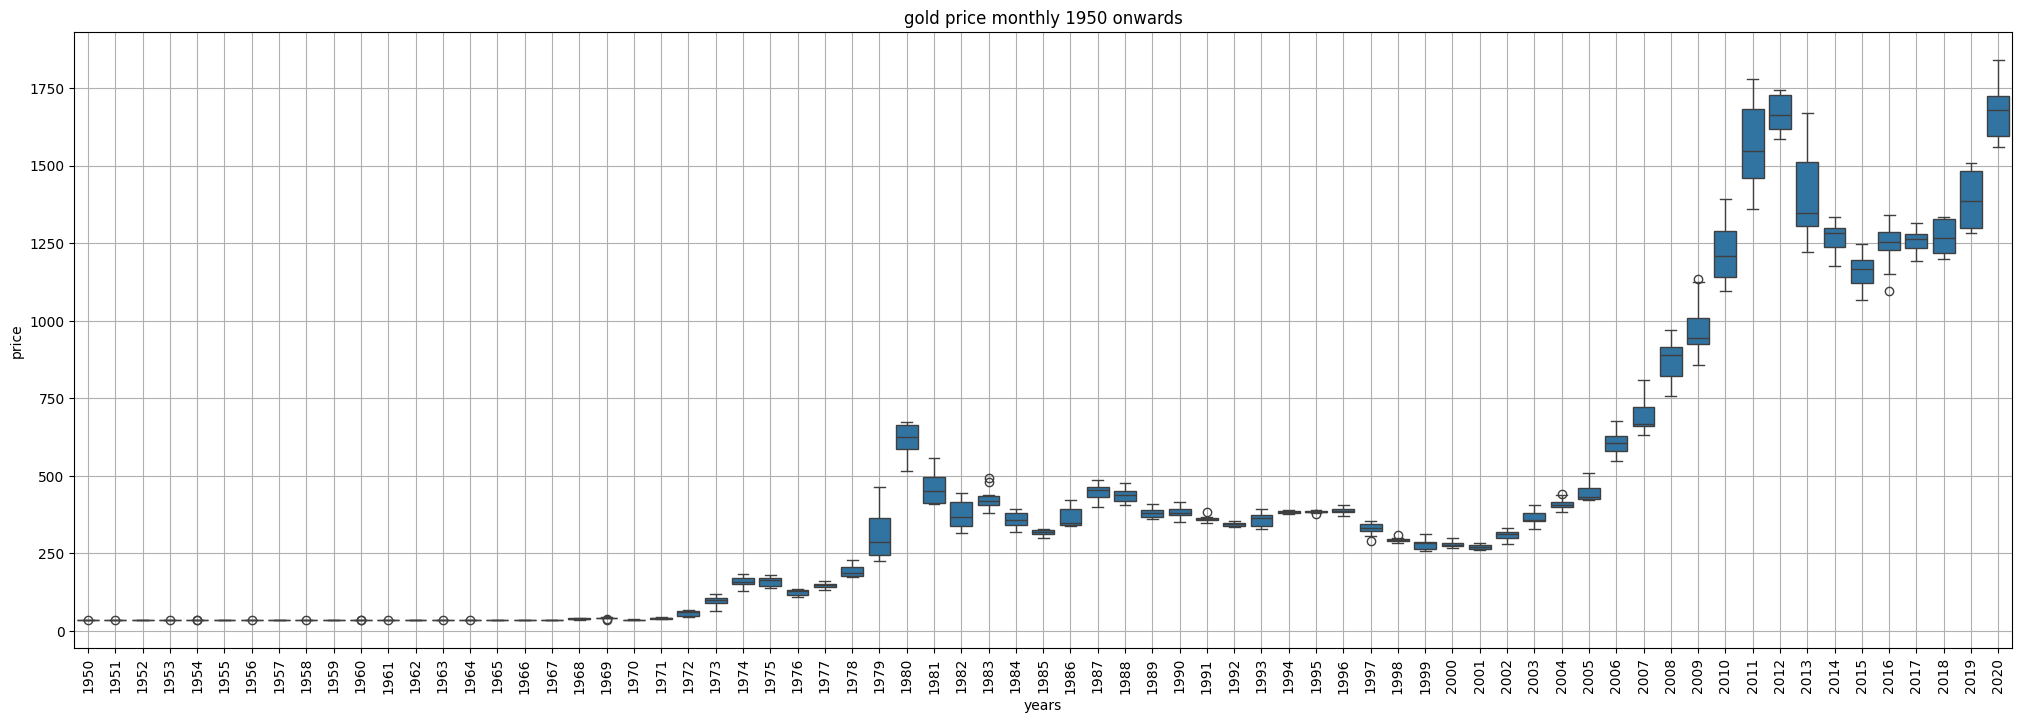

In [10]:
_, ax = plt.subplots(figsize=(25, 8))
sns.boxplot(x=df.index.year, y=df.values[:,0],  ax=ax)
plt.title('gold price monthly 1950 onwards')
plt.xlabel('years')
plt.ylabel('price')
plt.xticks(rotation = 90)
plt.grid()

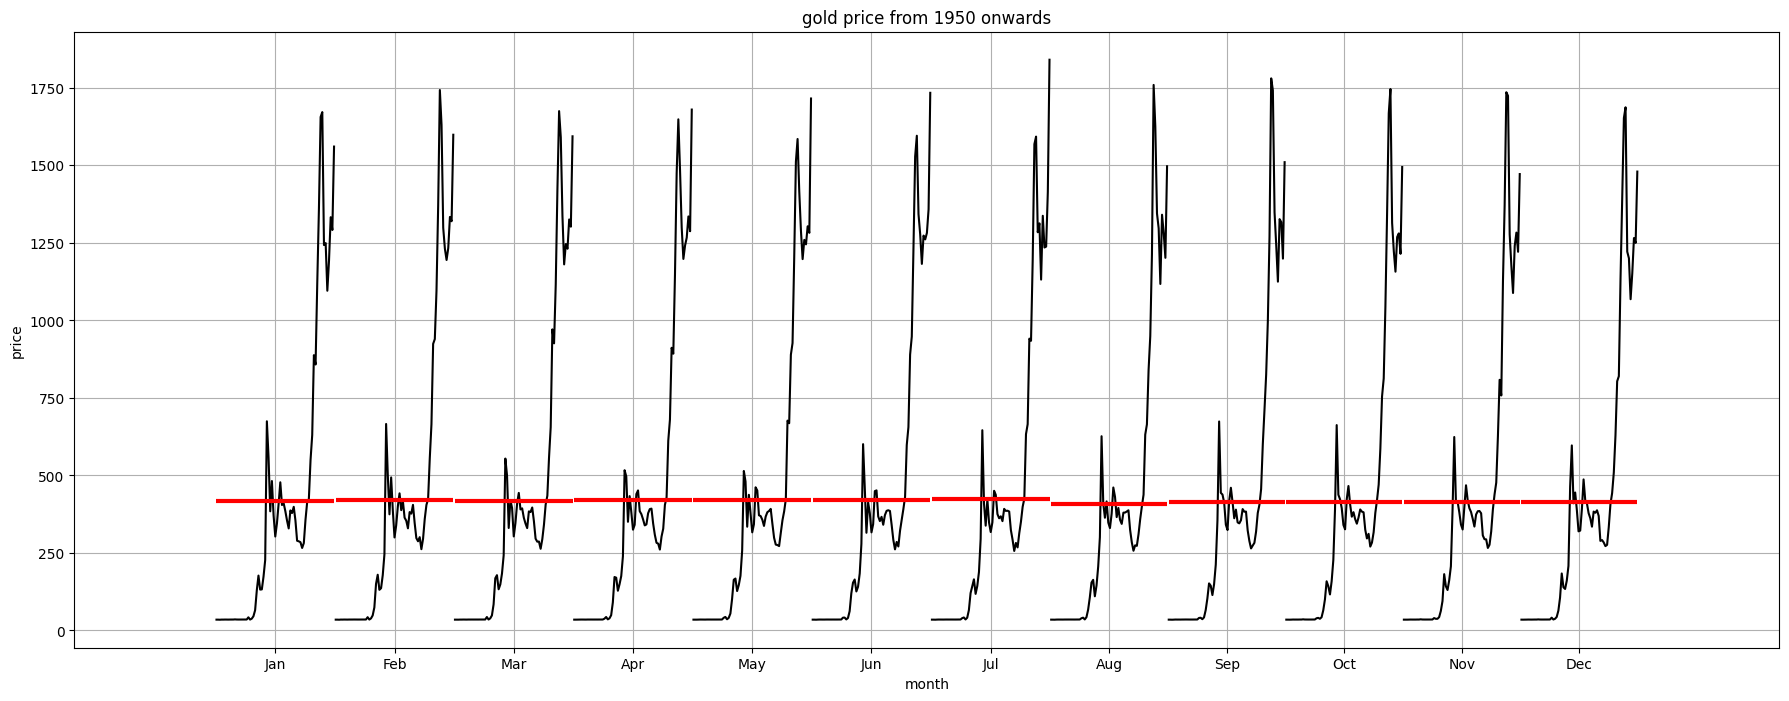

In [11]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize = (22, 8))
month_plot(df, ylabel='gold price', ax = ax)
plt.title('gold price from 1950 onwards')
plt.xlabel('month')
plt.ylabel('price')
plt.grid();

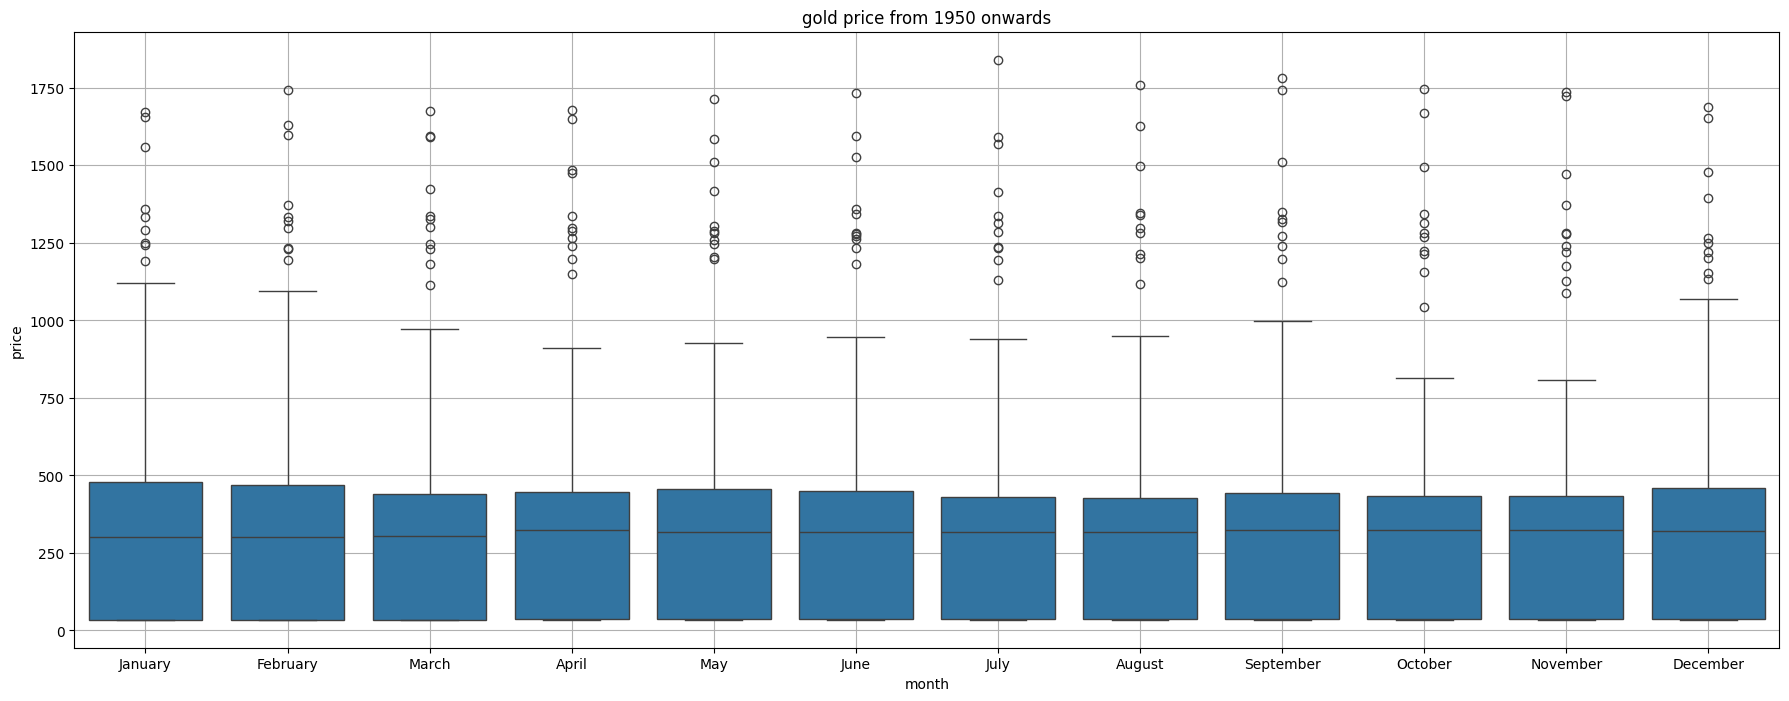

In [12]:
_, ax = plt.subplots(figsize = (22, 8))
sns.boxplot(x = df.index.month_name(), y = df.values[:, 0], ax = ax)
plt.title('gold price from 1950 onwards')
plt.xlabel('month')
plt.ylabel('price')
plt.grid();

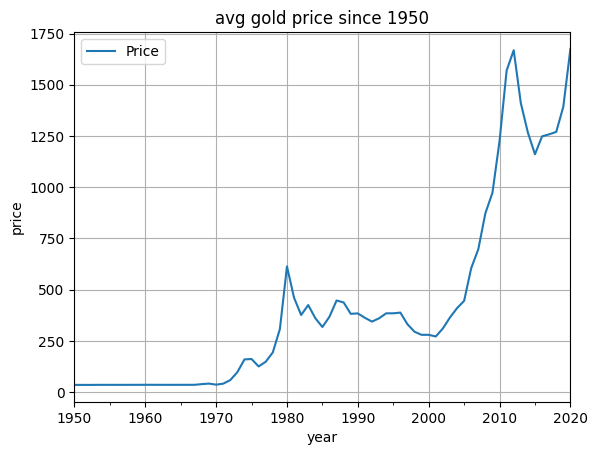

In [13]:
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot();
plt.title('avg gold price since 1950')
plt.xlabel('year')
plt.ylabel('price')
plt.grid();

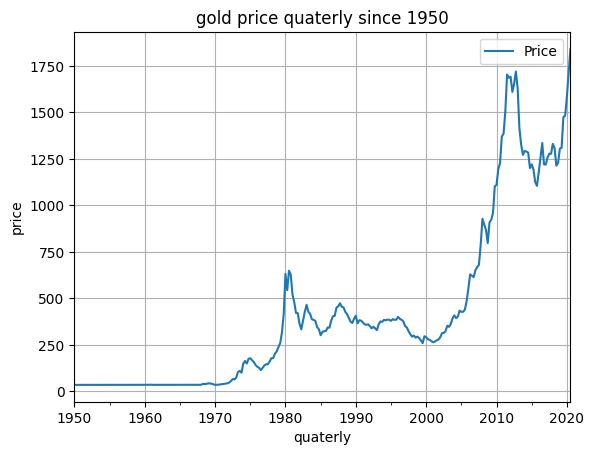

In [14]:
df_quaterly_sum = df.resample('Q').mean()
df_quaterly_sum.plot()
plt.title('gold price quaterly since 1950')
plt.xlabel('quaterly')
plt.ylabel('price')
plt.grid();

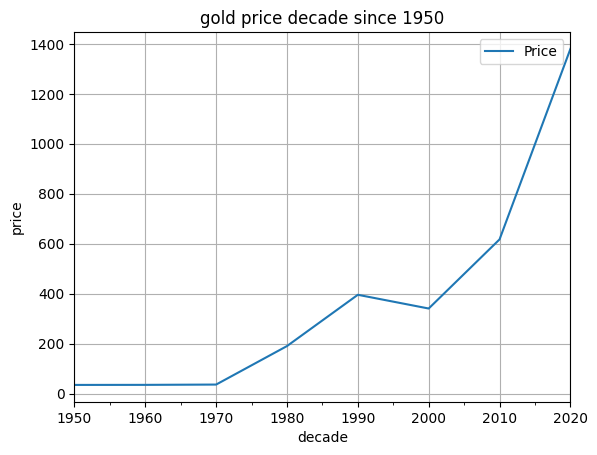

In [15]:
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot()
plt.title('gold price decade since 1950')
plt.xlabel('decade')
plt.ylabel('price')
plt.grid();

In [16]:
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price' : 'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price':'Std'}), left_index = True, right_index=True)
df_1['Cov_pct'] = ((df_1['Std']/df_1["Mean"])*100).round(2)
df_1.head()

,Mean,Std,Cov_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


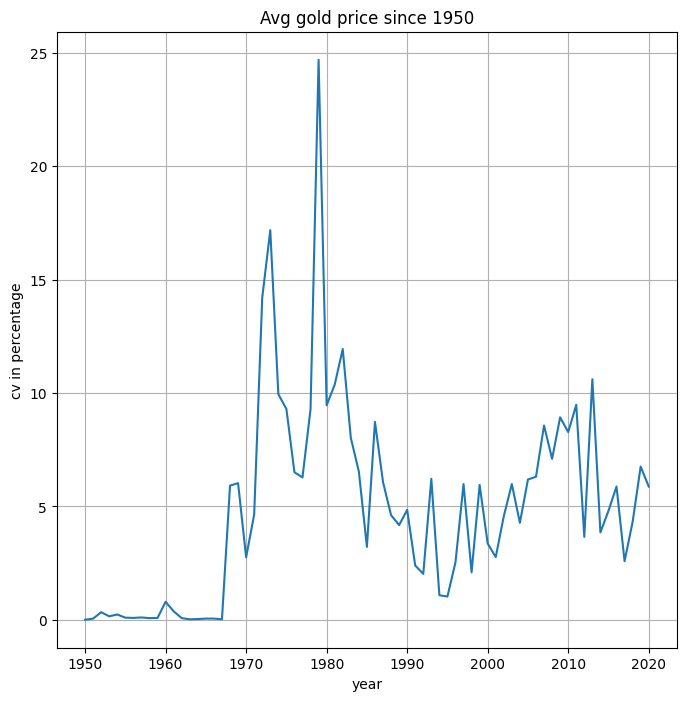

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
df_1['Cov_pct'].plot()
plt.title('Avg gold price since 1950')
plt.xlabel('year')
plt.ylabel('cv in percentage')
plt.grid();

In [18]:
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]

In [19]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


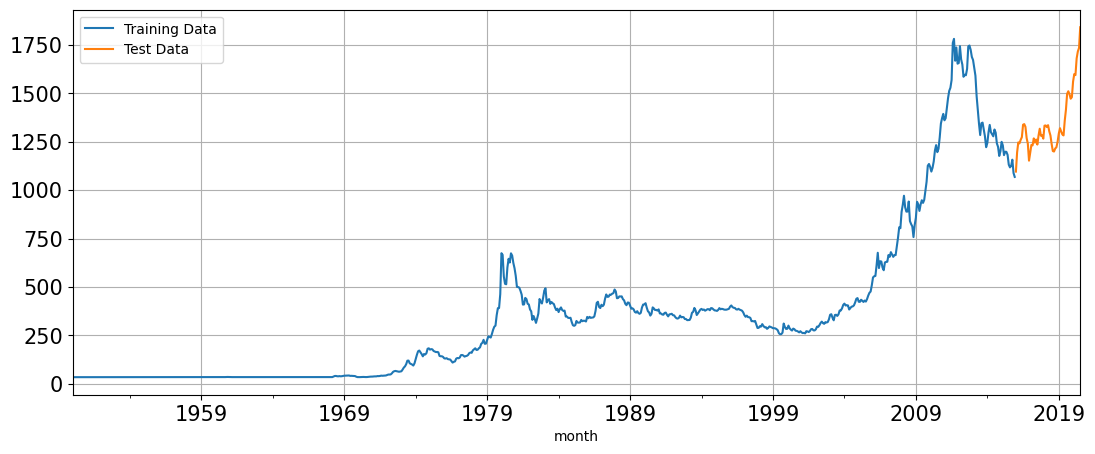

In [20]:
train['Price'].plot(figsize=(13,5), fontsize=15)
test['Price'].plot(figsize=(13,5), fontsize=15)
plt.grid()
plt.legend(['Training Data', 'Test Data'])

In [21]:
train_time = [(i+1) for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(792, 55)

In [22]:
LR_train = train.copy()
LR_test = test.copy()

In [23]:
LR_train['time'] = train_time
LR_test['time'] = test_time 

In [24]:
lr = LinearRegression()
lr.fit(LR_train[['time']], LR_train['Price'].values)

LinearRegression()

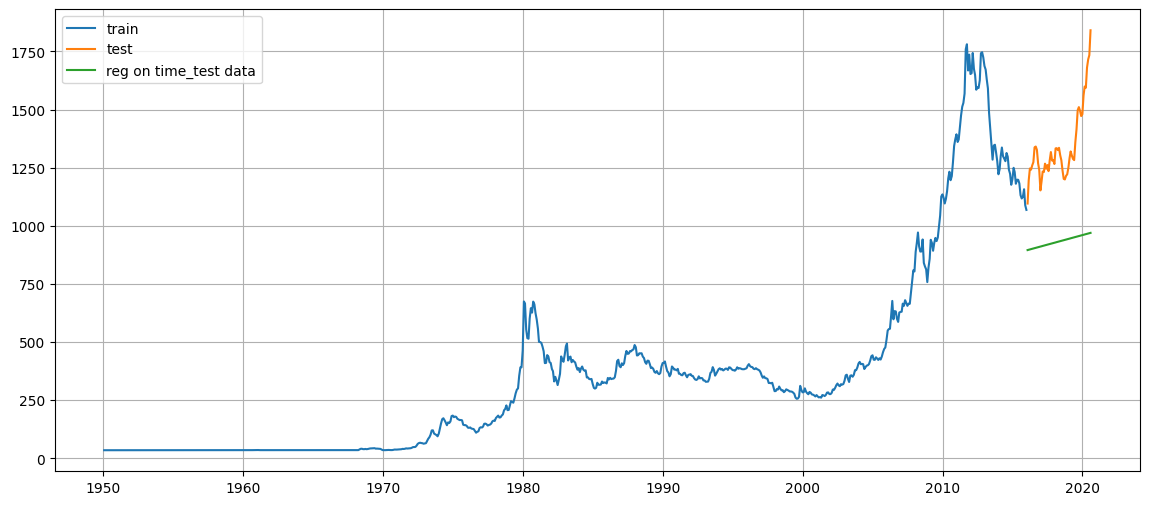

In [25]:
test_predictions_model1 = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_predictions_model1

plt.figure(figsize=(14, 6))
plt.plot(train[['Price']], label='train')
plt.plot(test[['Price']], label='test')
plt.plot(LR_test[['forecast']], label='reg on time_test data')
plt.legend(loc='best')
plt.grid();




In [26]:
def mape(actual, pred):
   return round((np.mean(abs(actual - pred)/actual))*100,2)

In [27]:
mape_model1_test = mape(test['Price'].values, test_predictions_model1)
print("Mape is %3.3f"%(mape_model1_test), "%")

Mape is 29.760 %


In [28]:
results = pd.DataFrame({'Test Mape (%)':[mape_model1_test]}, index=['RegressionOnTime'])
results

,Test Mape (%)
RegressionOnTime,29.76


In [29]:
Naive_train = train.copy()
Naive_test = test.copy()

Naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

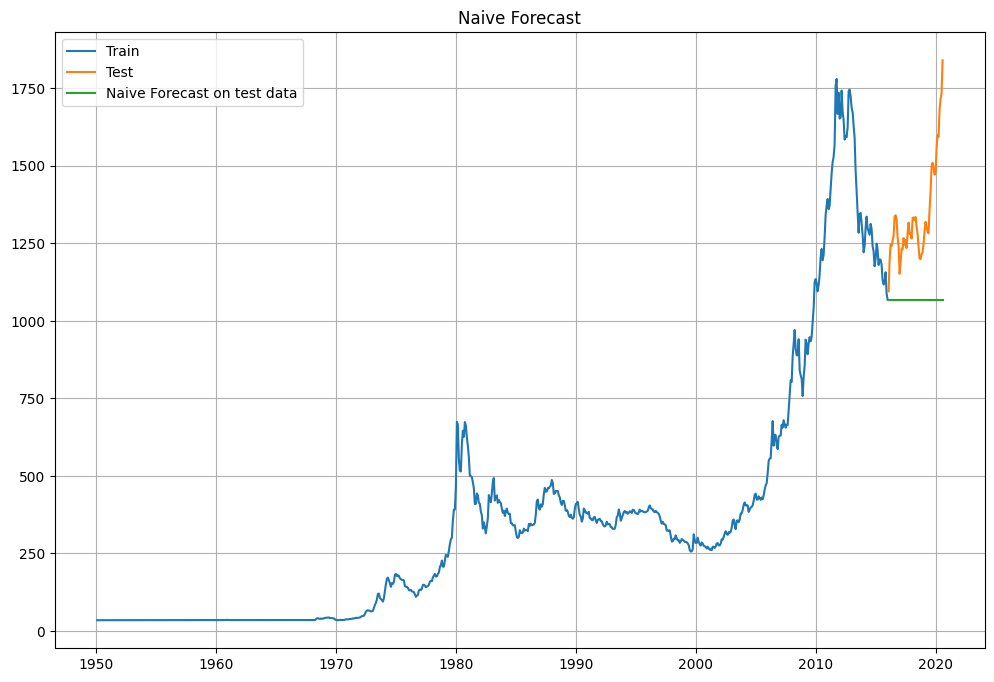

In [30]:
plt.figure(figsize=(12, 8))
plt.plot(Naive_train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(Naive_test['naive'], label = 'Naive Forecast on test data')
plt.legend(loc = 'best')
plt.title('Naive Forecast')
plt.grid()

In [31]:
final_model= ExponentialSmoothing(df, trend='additive', seasonal='additive').fit(smoothing_level = 0.4, smoothing_trend = 0.3, smoothing_seasonal=0.6)

Mape_final_model = mape(df['Price'].values, final_model.fittedvalues)
print("Mape : ", Mape_final_model)

Mape :  17.24


In [32]:
prediction = final_model.forecast(steps=len(test))

pred_df = pd.DataFrame({'lower_CI': prediction-1.96*np.std(final_model.resid, ddof=1),
                        'prediction' : prediction,
                        'upper_CI' : prediction+1.96*np.std(final_model.resid, ddof=1)})

pred_df.head() 

,lower_CI,prediction,upper_CI
2020-08-31,1684.718982,1792.869955,1901.020927
2020-09-30,1615.303307,1723.454279,1831.605251
2020-10-31,1538.563216,1646.714189,1754.865161
2020-11-30,1476.751963,1584.902935,1693.053908
2020-12-31,1459.318980,1567.469952,1675.620924


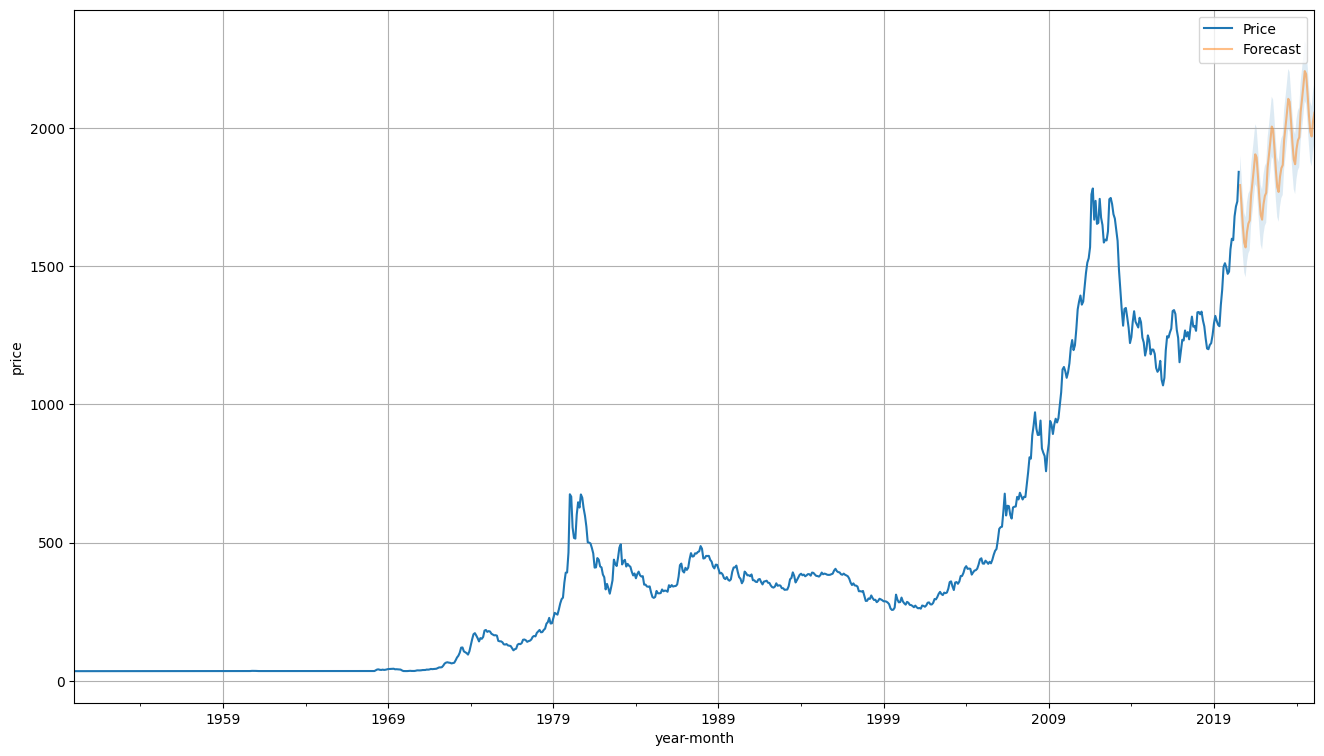

In [45]:
axis = df.plot(label = 'Actual', figsize=(16, 9))
pred_df['prediction'].plot(ax=axis, label = 'Forecast', alpha = 0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], alpha=0.15)
axis.set_xlabel('year-month')
axis.set_ylabel('price')
plt.legend(loc = 'best')
plt.grid();